<a href="https://colab.research.google.com/github/xAleksandraKitlas/lab9/blob/main/lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Najpierw wykonujemy instalacje środowiska

In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-f9fh0ztg
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-f9fh0ztg
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=45b9c5f80d54b9e762862db748cdb1671b505d18a7d76034bf34f20fb457aca2
  Stored in directory: /tmp/pip-ephem-wheel-cache-z8yhuqgw/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


**CPU**


In [ ]:
%%cu
#include <stdio.h>
// wartosc DIM ktora zmieniamy, zeby sprawdzic szybkosc
#define DIM 512
#define rnd( x ) (x * rand() / RAND_MAX)
#define INF 2e10f

//struktura przechowujaca sfere
struct Sphere {
    float   r,b,g;
    float   radius;
    float   x,y,z;
    float hit( float ox, float oy, float *n ) {
      float dx = ox - x;
      float dy = oy - y;
      if (dx*dx + dy*dy < radius*radius) {
        float dz = sqrtf( radius*radius - dx*dx - dy*dy );
        *n = dz / sqrtf( radius * radius );
        return dz + z;
      }
      return -INF;
    }
};

//ilosc sfer
#define SPHERES 20

//glowna funkcja wykonujaca obliczenia
void glownaFunkcja( Sphere *s, unsigned char *ptr, int x , int y ) {
    // map from threadIdx/BlockIdx to pixel position
    int offset = x + y * DIM;
    float   ox = (x - DIM/2);
    float   oy = (y - DIM/2);
  
    float   r=0, g=0, b=0;
    float   maxz = -INF;
    for(int i=0; i<SPHERES; i++) {
        float   n;
        float   t = s[i].hit( ox, oy, &n );
        if (t > maxz) {
          float fscale = n;
          r = s[i].r * fscale;
          g = s[i].g * fscale;
          b = s[i].b * fscale;
          maxz = t;
        }
    } 

    ptr[offset*4 + 0] = (int)(r * 255);
    ptr[offset*4 + 1] = (int)(g * 255);
    ptr[offset*4 + 2] = (int)(b * 255);
    ptr[offset*4 + 3] = 255;
}

struct DataBlock{
    unsigned char *dev_bitmap;
};

void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("CPU_reyTraced.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}


int main(void) {
  
  clock_t start, end;
  start = clock();
  
  DataBlock data;
  unsigned char *bitmap = (unsigned char*)malloc(DIM* DIM*4* sizeof(unsigned char));
  int image_size = DIM* DIM*4;
  Sphere *s;

  Sphere *temp_s = (Sphere*)malloc(sizeof(Sphere)* SPHERES );

  for (int i=0; i<SPHERES; i++) {
    temp_s[i].r = rnd( 1.0f);
    temp_s[i].g= rnd( 1.0f);
    temp_s[1].b= rnd( 1.0f);
    temp_s[i].x =rnd( 1000.0f)- 500;
    temp_s[i].y =rnd( 1000.0f) - 500;
    temp_s[1].z = rnd( 1000.0f) - 500;
    temp_s[i].radius = rnd( 100.0f) + 20;
  }

  s = temp_s;
  
  //tutaj zapisujemy do pliku
  for (int i=0; i<DIM; i++) {
    for (int j=0; j<DIM; j++) {
     glownaFunkcja(s, bitmap, i, j);
    }
  }

  save_to_file(bitmap);
  
  //liczymy czas
  end = clock();
  double elapsed_time = (double)(end - start) / CLOCKS_PER_SEC;
  printf("Compilation time: %f miliseconds\n", elapsed_time*1000);

}

Compilation time: 84.563000 miliseconds



**GPU**

In [6]:
%%cu
#include <stdio.h>

// wartosc DIM ktora zmieniamy, zeby sprawdzic szybkosc
#define DIM 2048
#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f

// Struktura przechowująca naszą sfere
struct Sphere {
    float r, b, g;
    float radius;
    float x, y, z;
    __device__ float hit(float ox, float oy, float *n) {
        float dx = ox - x;
        float dy = oy - y; 
        if (dx*dx + dy* dy < radius * radius) {
            float dz = sqrtf( radius * radius - dx*dx - dy*dy );
            *n = dz / sqrtf ( radius * radius );
            return dz + z;
        }
        return -INF;
    }
};
// ilosc SFER
#define SPHERES 20

//funkcja o nazwie kernel() z kwalifikatorem __global__ - informuje on
//kompilator o tym, że dana funkcja powinna zostać skompilowana dla
//urządzenia a nie hosta
__global__ void kernel (Sphere *s, unsigned char *ptr) {
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int offset = x + y * blockDim.x * gridDim.x;
    float ox = (x - DIM/2);
    float oy = (y - DIM/2);

    float r=0, g=0, b=0;
    float maxz = -INF;
    for(int i =0; i<SPHERES; i++) {
        float n;
        float t = s[i].hit( ox, oy, &n );
        if (t > maxz) {
            float fscale = n;
            r = s[i].r * fscale;
            g = s[i].g * fscale;
            b = s[i].b * fscale;
            maxz = t;
        }
    }
    ptr[offset*4 + 0] = (int)(r * 255);
    ptr[offset*4 + 1] = (int)(g * 255);
    ptr[offset*4 + 2] = (int)(b * 255);
    ptr[offset*4 + 3] = 255;
}

struct DataBlock{
    unsigned char *dev_bitmap;
};

//funkcja która zapisuje wartości rgb do pliku tekstowego
void save_to_file(unsigned char *ptr) {
    FILE *fp = fopen("ballz.txt","w");
    for(int y =0; y<DIM; y++){
        for (int x =0; x<DIM; x++){
            int offset = x+y*DIM;
            fprintf(fp, "\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1],ptr[offset*4+2],ptr[offset*4+3]);
        }
    }
    fclose(fp);
}

int main( void ) {
    cudaEvent_t start, stop;
    cudaEventCreate (&start);
    cudaEventCreate (&stop);
    cudaEventRecord( start, 0);

    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    unsigned char *dev_bitmap;

    cudaMalloc((void**)&dev_bitmap, image_size);
    data.dev_bitmap=dev_bitmap;
    Sphere *s;

    cudaMalloc((void**)&s, sizeof(Sphere) * SPHERES);
    Sphere *temp_s = (Sphere*)malloc( sizeof(Sphere) * SPHERES);
    for (int i = 0; i<SPHERES; i++) {
        temp_s[i].r = rnd ( 1.0f );
        temp_s[i].g = rnd ( 1.0f );
        temp_s[i].b = rnd ( 1.0f );
        temp_s[i].x = rnd( 1000.0f ) - 500;
        temp_s[i].y = rnd( 1000.0f ) - 500;
        temp_s[i].z = rnd( 1000.0f ) - 500;
        temp_s[i].radius = rnd(100.0f) + 20;
    }
    cudaMemcpy( s, temp_s, sizeof(Sphere) * SPHERES, cudaMemcpyHostToDevice );
    free (temp_s );
    

    // tutaj zapisujemy nasza bitmape do pliku txt
    dim3 grids(DIM/16, DIM/16);
    dim3 threads(16,16);
    kernel<<<grids, threads>>>(s, dev_bitmap);
    cudaMemcpy(bitmap, dev_bitmap, image_size, cudaMemcpyDeviceToHost);
    cudaEventRecord( stop, 0 );
    cudaEventSynchronize(stop);
    float elapsedTime;
    cudaEventElapsedTime ( &elapsedTime, start, stop);
    printf( "Time to generate: %3.1f ms\n", elapsedTime );

    cudaEventDestroy( start );
    cudaEventDestroy (stop);
    cudaFree( dev_bitmap );
    cudaFree( s );

    save_to_file(bitmap);

}


Time to generate: 7.3 ms



Zmieniałam wymiary ręcznie w obu wypadkach: <br>
DIM 512<br>
Czas wykonania programu na CPU: 84.56 milisekund<br>
Czas wykonania programu na GPU: 0.677428 milisekund <br>
DIM 1024 <br>
Czas wykonania programu na CPU: 373.26 milisekund <br>
Czas wykonania programu na GPU: 1.7<br>
DIM 2048 <br>
Czas wykonania programu na CPU: 1438.9 milisekund <br>
Czas wykonania programu na GPU: 7.5 milisekund <br>
DIM 4096<br>
Czas wykonania programu na CPU: 5796.87 milisekund <br>
Czas wykonania programu na GPU: 45.5 milisekund <br>


**WYKRES**

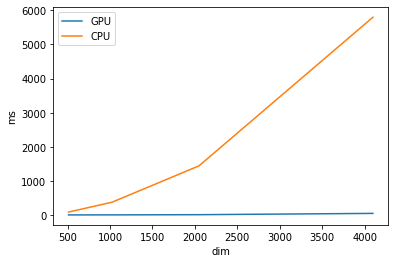

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# tablice z czasami CPU, GPU i badanymi DIM
timeCPU = [84.56, 373.26, 1438.9, 5796.87]
timeGPU = [0.677428, 1.7, 7.5, 45.5]
DIM = [512, 1024, 2048, 4096]
# tutaj rysujemy wykresy za pomoca matplotlib
plt.plot(DIM, timeGPU, label = "GPU")
plt.plot(DIM, timeCPU, label = "CPU")
plt.ylabel("ms")
plt.xlabel("dim")
plt.legend()
plt.show()

**WNIOSKI**<br>
jak widać czas wykonania na GPU jest o wiele szybszy i bardziej liniowy niz czas wykonania na CPU. <br>
Widzimy znaczącą poprawę czasu używając CUDA.